### Customer Churn Analysis of Brazillian e-commerce

In [2]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="ticks")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import sklearn
import scipy
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
%matplotlib inline

In [3]:
#Customized plotting functions for visualizations
def format_spines(ax, right_border=True):
    
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')

def count_plot(feature, df, colors='Greens_d', hue=False, ax=None, title=''):
    
    # Preparing variables
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax)
        
    format_spines(ax)
    
    # Setting percentage
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]

        ax.annotate(y, (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    
    # Final configuration
    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()
    
    
def bar_plot(x, y, df, colors='Blues_d', hue=False, ax=None, value=False, title=''):
    
    # Preparing variables
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    #fig, ax = plt.subplots()
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    # Setting borders
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()
    
    
def categorical_plot(cols_cat, axs, df):
    
    idx_row = 0
    for col in cols_cat:
        # Returning column index
        idx_col = cols_cat.index(col)

        # Verifying brake line in figure (second row)
        if idx_col >= 3:
            idx_col -= 3
            idx_row = 1

        # Plot params
        names = df[col].value_counts().index
        heights = df[col].value_counts().values

        # Bar chart
        axs[idx_row, idx_col].bar(names, heights, color='navy')
        if (idx_row, idx_col) == (0, 2):
            y_pos = np.arange(len(names))
            axs[idx_row, idx_col].tick_params(axis='x', labelrotation=30)
        if (idx_row, idx_col) == (1, 1):
            y_pos = np.arange(len(names))
            axs[idx_row, idx_col].tick_params(axis='x', labelrotation=90)

        total = df[col].value_counts().sum()
        axs[idx_row, idx_col].patch.set_facecolor('#FFFFFF')
        format_spines(axs[idx_row, idx_col], right_border=False)
        for p in axs[idx_row, idx_col].patches:
            w, h = p.get_width(), p.get_height()
            x, y = p.get_xy()
            axs[idx_row, idx_col].annotate('{:.1%}'.format(h/1000), (p.get_x()+.29*w,
                                            p.get_y()+h+20), color='k')

        # Plot configuration
        axs[idx_row, idx_col].set_title(col, size=12)
        axs[idx_row, idx_col].set_ylim(0, heights.max()+120)

In [6]:
#Load Data
order = pd.read_csv('Data/olist_orders_dataset.csv')
customer = pd.read_csv('Data/olist_customers_dataset.csv')
review = pd.read_csv('Data/olist_order_reviews_dataset.csv')
payment = pd.read_csv('Data/olist_order_payments_dataset.csv')
order_item = pd.read_csv('Data/olist_order_items_dataset.csv')
product = pd.read_csv('Data/olist_products_dataset.csv')
seller = pd.read_csv('Data/olist_sellers_dataset.csv')
geo = pd.read_csv('Data/olist_geolocation_dataset.csv')
translation = pd.read_csv('Data/product_category_name_translation.csv')

In [201]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [7]:
#Convert Timestamp Data
order_date=['order_purchase_timestamp', 'order_approved_at',
            'order_delivered_carrier_date', 'order_delivered_customer_date',
            'order_estimated_delivery_date']
for items in order_date:
    order[items] = pd.to_datetime(order[items],format='%d/%m/%Y %H:%M')

#### We will merge the different datasets based on the data schema

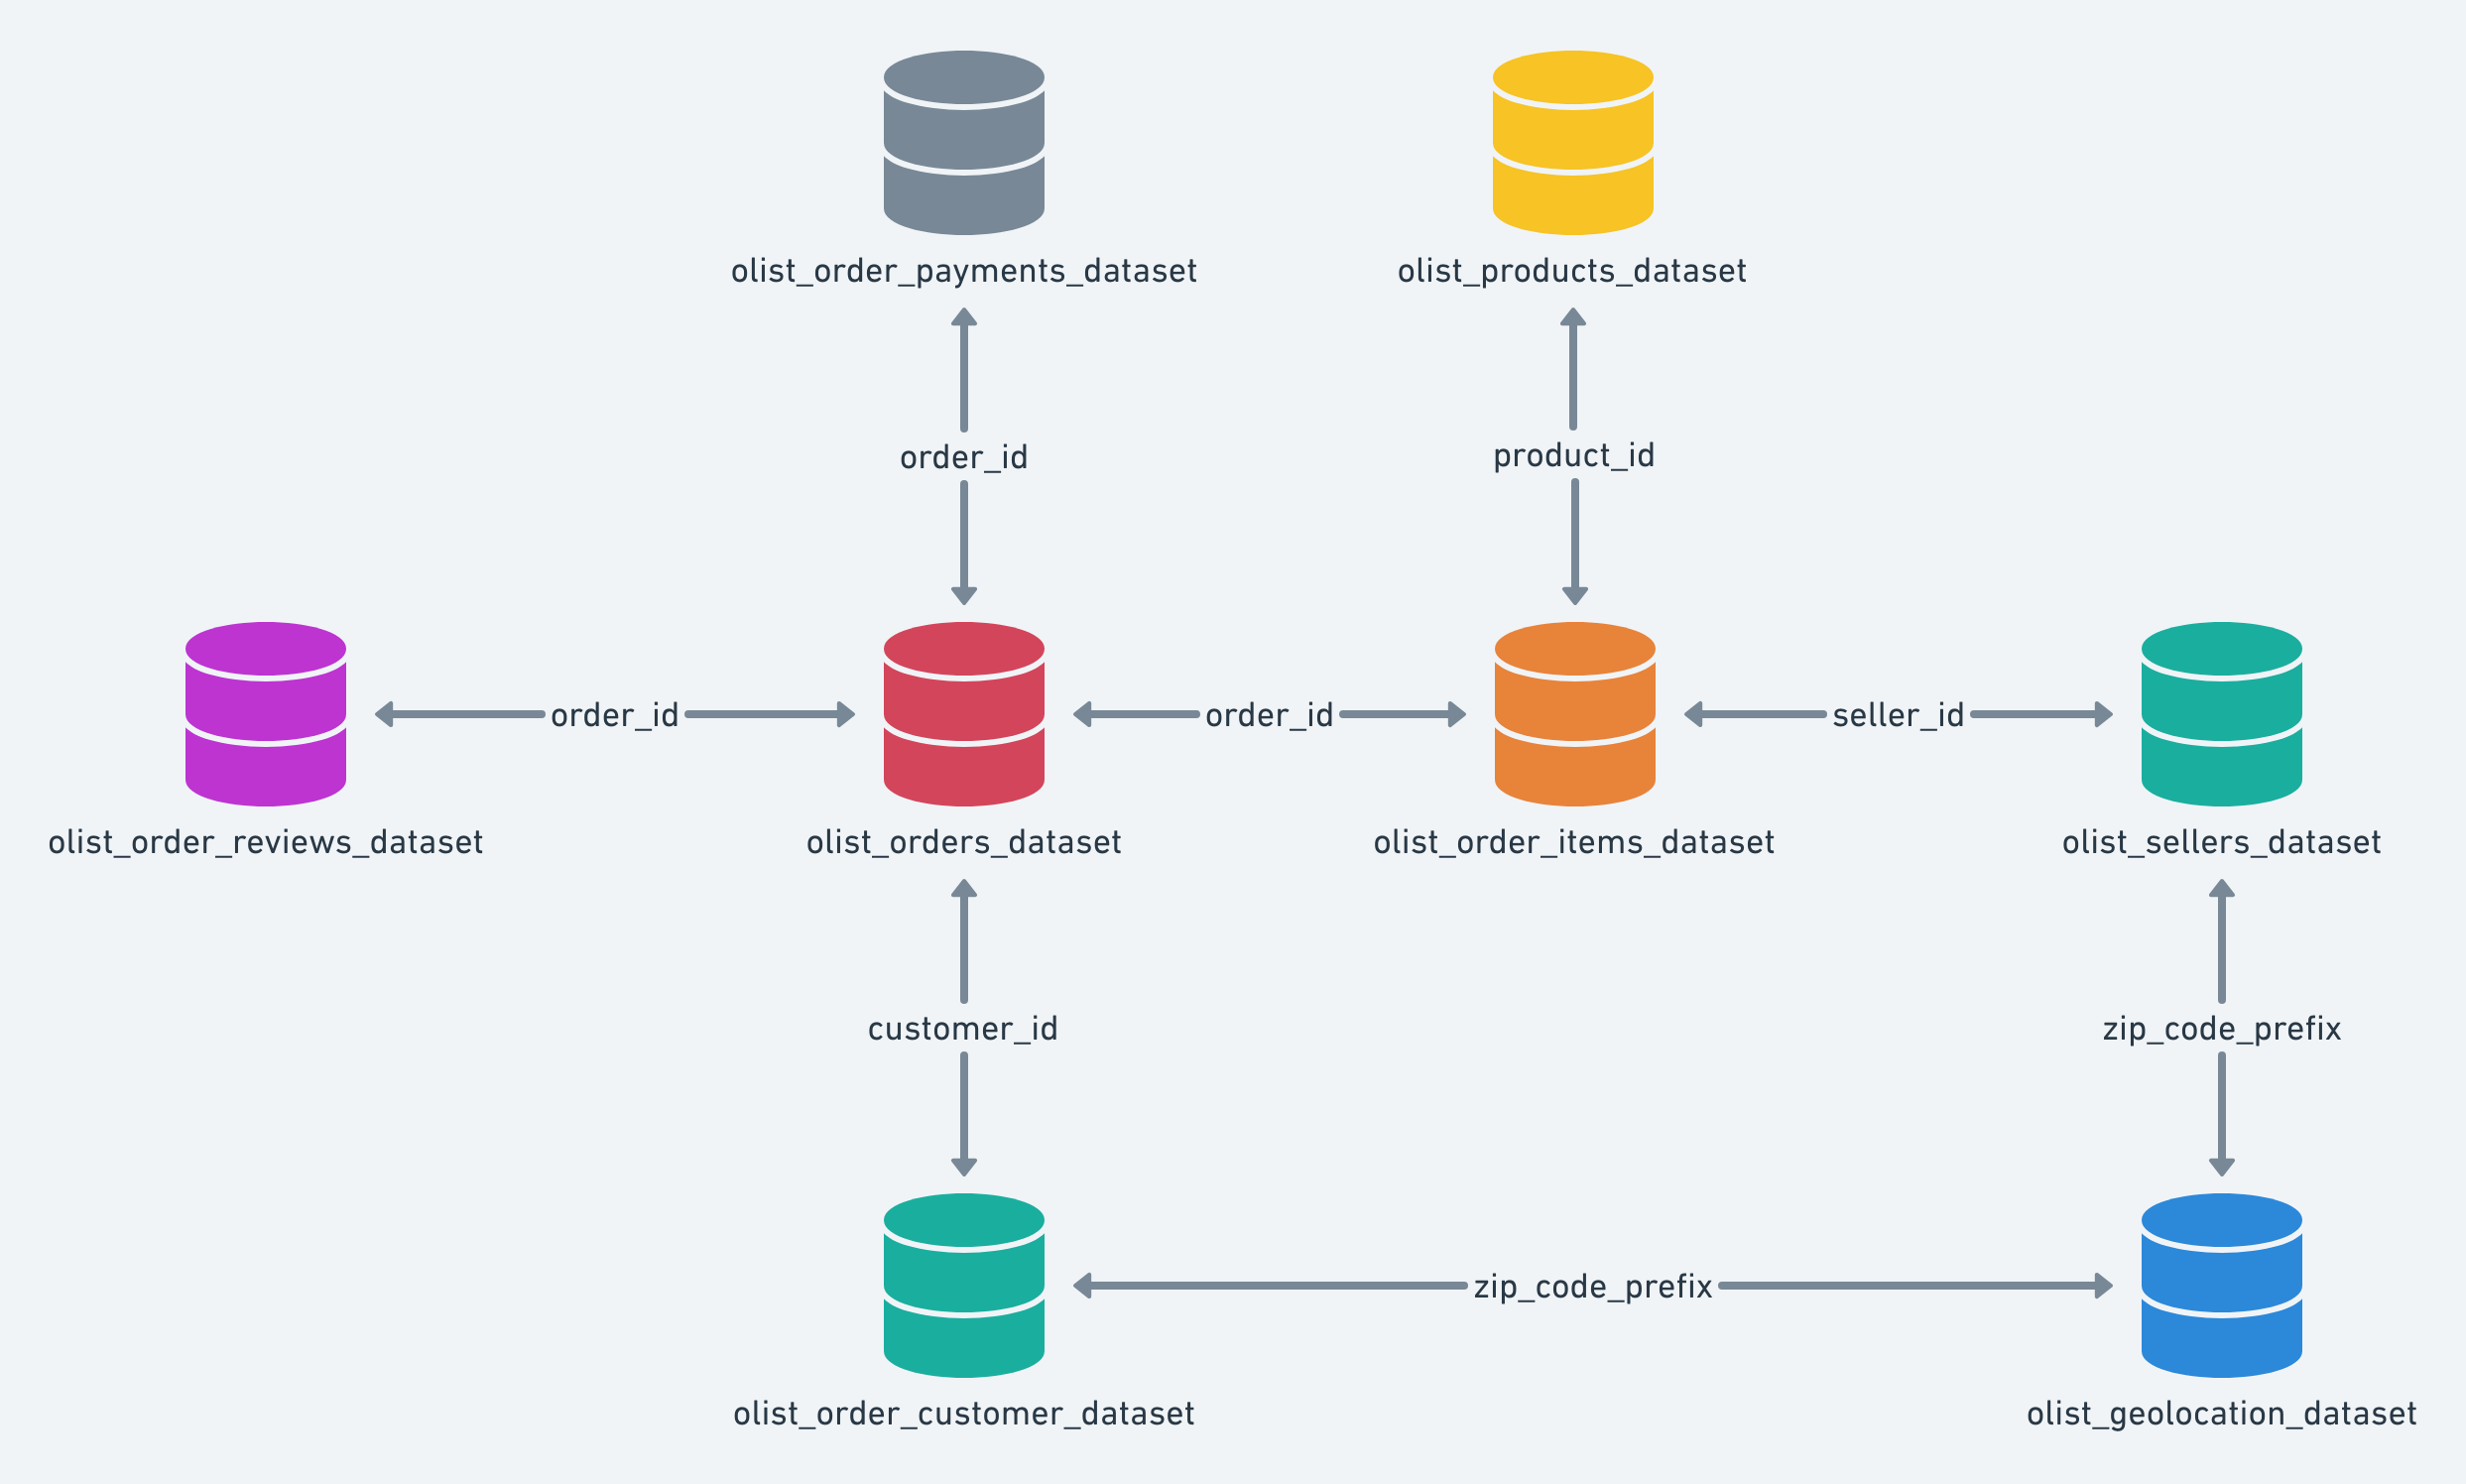

In [9]:
from IPython.display import Image
Image("Data/brazillian dataset schema.png")

In [203]:
order

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp   order_approved_at  \
0        delivered      2017-10-02 10:56:00 2017-10-02 11:07:00   
1        delivered      2018-07-24 20:41:00 2018-07-26 03:24:00   
2        delivered      2018-08-08 08:38:00 2018-08-08 08:55:00   
3        delivered      2017-11-18 19:28:00 2017-11-18 19:45:00   
4        delivered      2018-02-13 21:18:00 2018-02-13 22:20:00   
...            ...                      ...                 ...   
99436    delivered      2017-03-09 09:54:00 2017-03-09 09:54:00   
99437    delivered      2018-02-06 12:58:00 2018-02-06 13:10:00   
99438    delivered      2017-08-27 14:46:00 2017-08-27 15:04:00   
99439    delivered      2018-01-08 21:28:00 2018-01-08 21:36:00   
99440    delivered      2018-03-08 20:57:00 2018-03-09 11:20:00   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:00   
1              2018-07-26 14:31:00           2018-08-07 15:27:00   
2              2018-08-08 13:50:00           2018-08-17 18:06:00   
3              2017-11-22 13:39:00           2017-12-02 00:28:00   
4              2018-02-14 19:46:00           2018-02-16 18:17:00   
...                            ...                           ...   
99436          2017-03-10 11:18:00           2017-03-17 15:08:00   
99437          2018-02-07 23:22:00           2018-02-28 17:37:00   
99438          2017-08-28 20:52:00           2017-09-21 11:24:00   
99439          2018-01-12 15:35:00           2018-01-25 23:32:00   
99440          2018-03-09 22:11:00           2018-03-16 13:08:00   

      order_estimated_delivery_date  
0                        2017-10-18  
1                        2018-08-13  
2                        2018-09-04  
3                        2017-12-15  
4                        2018-02-26  
...                             ...  
99436                    2017-03-28  
99437                    2018-03-02  
99438                    2017-09-27  
99439                    2018-02-15  
99440                    2018-04-03  

[99441 rows x 8 columns]

In [204]:
payment.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

In [205]:
order_item.head(3)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   

  shipping_limit_date  price  freight_value  
0     19/09/2017 9:45   58.9          13.29  
1    03/05/2017 11:05  239.9          19.93  
2    18/01/2018 14:48  199.0          17.87

In [206]:
product.head(1)

product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5            perfumaria   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0

In [207]:
review.head(2)

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   

   review_score review_comment_title review_comment_message  \
0             4                  NaN                    NaN   
1             5                  NaN                    NaN   

  review_creation_date review_answer_timestamp  
0      18/01/2018 0:00        18/01/2018 21:46  
1      10/03/2018 0:00         11/03/2018 3:05

In [208]:
# creating master dataframe 
payment.head()
print(payment.shape)
df1 = payment.merge(order_item, on='order_id')
print(df1.shape)
df2 = df1.merge(product, on='product_id')
print(df2.shape)
df3 = df2.merge(seller, on='seller_id')
print(df3.shape)
df4 = df3.merge(review, on='order_id')
print(df4.shape)
df5 = df4.merge(order, on='order_id')
print(df5.shape)
df6 = df5.merge(translation, on='product_category_name')
print(df6.shape)
df = df6.merge(customer, on='customer_id')
print(df.shape)

(103886, 5)
(117601, 11)
(117601, 19)
(117601, 22)
(118315, 28)
(118315, 35)
(116581, 36)
(116581, 40)


In [237]:
df.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  d86305c284cecff56c7ee9d3fbd4f8d6                   1  credit_card   
2  5308fdab519f7478ef64894128fbbee4                   1  credit_card   
3  5308fdab519f7478ef64894128fbbee4                   2      voucher   
4  bb54e9bf4bdb6c6391a7c6b517748b9f                   1  credit_card   

   payment_installments  payment_value  order_item_id  \
0                     8          99.33              1   
1                     4          93.72              1   
2                     1          36.07              1   
3                     1         112.67              1   
4                     2         124.92              1   

                         product_id                         seller_id  \
0  af74cc53dcffc8384b29e7abfa41902b  213b25e6f54661939f11710a6fddb871   
1  af74cc53dcffc8384b29e7abfa41902b  213b25e6f54661939f11710a6fddb871   
2  1b93af229a5768eaaed2064722b1c1dc  213b25e6f54661939f11710a6fddb871   
3  1b93af229a5768eaaed2064722b1c1dc  213b25e6f54661939f11710a6fddb871   
4  71540d636652fc682032d3b3c0a180c1  213b25e6f54661939f11710a6fddb871   

  shipping_limit_date   price  freight_value product_category_name  \
0    02/05/2018 22:15   79.80          19.53       casa_construcao   
1    19/04/2018 23:10   79.80          13.92       casa_construcao   
2    11/06/2018 12:11  129.95          18.79       casa_construcao   
3    11/06/2018 12:11  129.95          18.79       casa_construcao   
4    04/06/2018 11:50  113.85          11.07       casa_construcao   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 57.0                       921.0                 8.0   
1                 57.0                       921.0                 8.0   
2                 57.0                       915.0                 5.0   
3                 57.0                       915.0                 5.0   
4                 54.0                       923.0                 8.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             800.0               17.0               27.0              17.0   
1             800.0               17.0               27.0              17.0   
2            9950.0               52.0               22.0              52.0   
3            9950.0               52.0               22.0              52.0   
4            1050.0               16.0               27.0              16.0   

   seller_zip_code_prefix seller_city seller_state  \
0                   13321       salto           SP   
1                   13321       salto           SP   
2                   13321       salto           SP   
3                   13321       salto           SP   
4                   13321       salto           SP   

                          review_id  review_score review_comment_title  \
0  4ce650e117a5b292bf5ea980a61eb61e             1        Não recomendo   
1  ec9d84039245b981ebdbf7d16c723b6e             4                  NaN   
2  8c4799d2bd4f23b35cf959e0cd301b4d             5   Produto muito bom.   
3  8c4799d2bd4f23b35cf959e0cd301b4d             5   Produto muito bom.   
4  74ee8b3ec46cf56eb0b1349ff526025a             3                  NaN   

                              review_comment_message review_creation_date  \
0  Produto com qualidade ruim, amassado e descasc...      10/05/2018 0:00   
1                                                NaN      21/04/2018 0:00   
2                                                NaN      21/06/2018 0:00   
3                                                NaN      21/06/2018 0:00   
4                                                NaN      27/06/2018 0:00   

  review_answer_timestamp                       customer_id order_status  \
0        15/05/2018 23:38  0a8556ac6be836b46b3e89920d59291c    delivered   
1        21/04/2018 10:31  0e37385834260d6111727103a93e790a    delivered   
2        2

In [210]:
#cleaning up and re-engineering some columns
df['order_purchase_year'] = df.order_purchase_timestamp.apply(lambda x: x.year)
df['order_purchase_month'] = df.order_purchase_timestamp.apply(lambda x: x.month)
df['order_purchase_dayofweek'] = df.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df['order_purchase_hour'] = df.order_purchase_timestamp.apply(lambda x: x.hour)
df['order_purchase_day'] = df['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df['order_purchase_mon'] = df.order_purchase_timestamp.apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
df['order_count']=1
df['year_month'] = df['order_purchase_timestamp'].dt.strftime('%Y-%m')

df['ship_duration']=(df['order_delivered_customer_date']-df['order_purchase_timestamp'])/24
df['ship_duration']=df['ship_duration'].astype('timedelta64[h]')

df['tocarrier_duration']=(df['order_delivered_carrier_date']-df['order_purchase_timestamp'])/24
df['tocarrier_duration']=df['tocarrier_duration'].astype('timedelta64[h]')

df['lastmile_duration']=(df['order_delivered_customer_date']-df['order_delivered_carrier_date'])/24
df['lastmile_duration']=df['lastmile_duration'].astype('timedelta64[h]')

df['expected_vs_shipdate']=(df['order_estimated_delivery_date']-df['order_delivered_customer_date'])/24
df['expected_vs_shipdate']=df['expected_vs_shipdate'].astype('timedelta64[h]')

df['expected_duration']=(df['order_estimated_delivery_date']-df['order_purchase_timestamp'])/24
df['expected_duration']=df['expected_duration'].astype('timedelta64[h]')

In [211]:
# displaying first 3 rows of master dataframe
df.head(3)

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  d86305c284cecff56c7ee9d3fbd4f8d6                   1  credit_card   
2  5308fdab519f7478ef64894128fbbee4                   1  credit_card   

   payment_installments  payment_value  order_item_id  \
0                     8          99.33              1   
1                     4          93.72              1   
2                     1          36.07              1   

                         product_id                         seller_id  \
0  af74cc53dcffc8384b29e7abfa41902b  213b25e6f54661939f11710a6fddb871   
1  af74cc53dcffc8384b29e7abfa41902b  213b25e6f54661939f11710a6fddb871   
2  1b93af229a5768eaaed2064722b1c1dc  213b25e6f54661939f11710a6fddb871   

  shipping_limit_date   price  freight_value product_category_name  \
0    02/05/2018 22:15   79.80          19.53       casa_construcao   
1    19/04/2018 23:10   79.80          13.92       casa_construcao   
2    11/06/2018 12:11  129.95          18.79       casa_construcao   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 57.0                       921.0                 8.0   
1                 57.0                       921.0                 8.0   
2                 57.0                       915.0                 5.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             800.0               17.0               27.0              17.0   
1             800.0               17.0               27.0              17.0   
2            9950.0               52.0               22.0              52.0   

   seller_zip_code_prefix seller_city seller_state  \
0                   13321       salto           SP   
1                   13321       salto           SP   
2                   13321       salto           SP   

                          review_id  review_score review_comment_title  \
0  4ce650e117a5b292bf5ea980a61eb61e             1        Não recomendo   
1  ec9d84039245b981ebdbf7d16c723b6e             4                  NaN   
2  8c4799d2bd4f23b35cf959e0cd301b4d             5   Produto muito bom.   

                              review_comment_message review_creation_date  \
0  Produto com qualidade ruim, amassado e descasc...      10/05/2018 0:00   
1                                                NaN      21/04/2018 0:00   
2                                                NaN      21/06/2018 0:00   

  review_answer_timestamp                       customer_id order_status  \
0        15/05/2018 23:38  0a8556ac6be836b46b3e89920d59291c    delivered   
1        21/04/2018 10:31  0e37385834260d6111727103a93e790a    delivered   
2        24/06/2018 20:43  3aec6e3846fd122ac430ac1a816107a8    delivered   

  order_purchase_timestamp   order_approved_at order_delivered_carrier_date  \
0      2018-04-25 22:01:00 2018-04-25 22:15:00          2018-05-02 15:20:00   
1      2018-04-15 22:53:00 2018-04-15 23:10:00          2018-04-16 23:54:00   
2      2018-06-02 11:51:00 2018-06-02 12:11:00          2018-06-05 15:02:00   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2018-05-09 17:36:00                    2018-05-22   
1           2018-04-20 00:07:00                    2018-05-09   
2           2018-06-20 23:09:00                    2018-07-13   

  product_category_name_english                customer_unique_id  \
0             home_construction  708ab75d2a007f0564aedd11139c7708   
1             home_construction  550a1a0e8ad53e4147e6c761b5699c2b   
2             home_construction  74fe4e106702770ef728399ce5da503a   

   customer_zip_code_prefix  customer_city customer_state  \
0                     39801  teofilo otoni             MG   
1                     14781       barretos             SP   
2                     74823        goiania             GO   

   order_purchase_year  order_purchase_month  order_purchase_dayofweek  \
0                 2

# Time Series Analysis

*** Context:** We observed that new user growth has gradually slowed over the last year. In the past few months, customer churn is up to 10% from last year. No obvious change in product or major bug. 

*** Question:** why are retailers churning?

*** Analysis Direction:** We will discover the reasons for retailer churn by analyzing three dimensions: 
1. Customers Analysis: New User, Retention (repeated purchases) - Any trends YoY? Anythings standout by Geo?
2. Order Analysis: Order volume (take into account seasonality) & value
3. Review Analysis: Any significant degrade in CSAT(Customer Satisfaction)

# Orders Volume and Sales Analysis
Observations: Order purchase was on a rise throughout 2017, and suddenly came to a plateau in 2018 and has been on a downward trend. Both order's volume and order's value have reduced in 2018 

This reduction on order volume and sales happened very sudden at the start of 2018, across all geos.

In [212]:
df_sales = df.groupby(['order_purchase_year', 'order_purchase_month','year_month'], as_index=False).sum().loc[:, ['order_purchase_year', 'order_purchase_month','year_month', 'payment_value','order_count']]

In [213]:
df_sales.head()

order_purchase_year  order_purchase_month year_month  payment_value  \
0                 2016                     9    2016-09         347.52   
1                 2016                    10    2016-10       74677.62   
2                 2016                    12    2016-12          19.62   
3                 2017                     1    2017-01      187524.53   
4                 2017                     2    2017-02      335323.29   

   order_count  
0            3  
1          384  
2            1  
3         1010  
4         2014

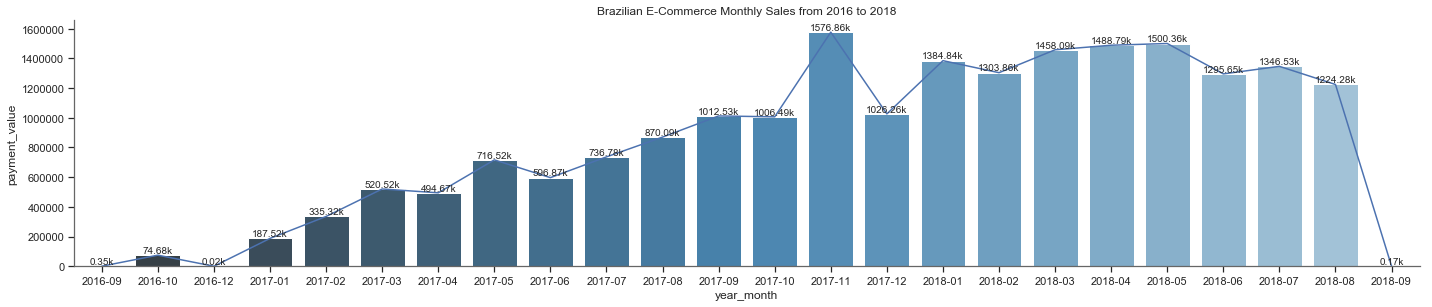

In [214]:
fig, ax = plt.subplots(figsize=(20, 4.5))
ax = sns.lineplot(x='year_month', y='payment_value', data=df_sales)
bar_plot(x='year_month', y='payment_value', df=df_sales, value=True)
format_spines(ax, right_border=False)
ax.set_title('Brazilian E-Commerce Monthly Sales from 2016 to 2018');

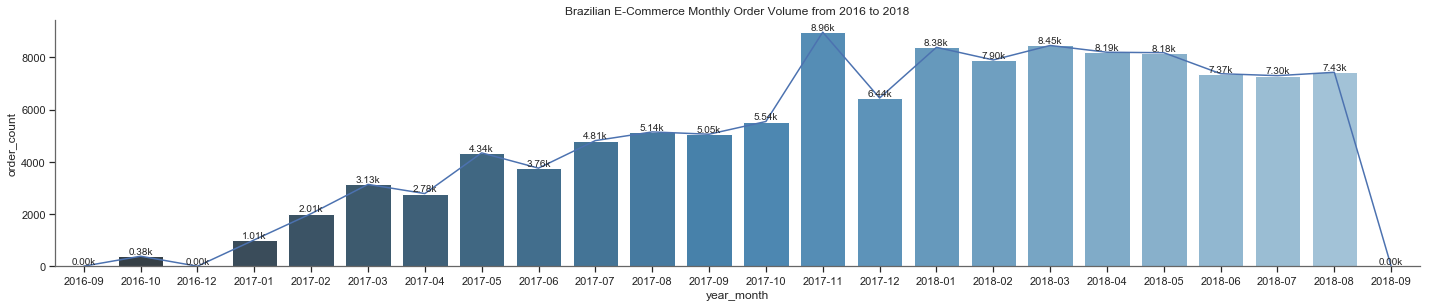

In [215]:
fig, ax = plt.subplots(figsize=(20, 4.5))
ax = sns.lineplot(x='year_month', y='order_count', data=df_sales)
bar_plot(x='year_month', y='order_count', df=df_sales, value=True)
format_spines(ax, right_border=False)
ax.set_title('Brazilian E-Commerce Monthly Order Volume from 2016 to 2018');


   The trend shows a general increase in volume and sales of products.

In [216]:
# Grouping by customer state
df_cus_count = df.groupby(['order_purchase_year', 'order_purchase_month','year_month'], as_index=False).nunique().loc[:, ['order_purchase_year', 'order_purchase_month','year_month', 'customer_unique_id','seller_id']]
df_cus_count.head(10)

order_purchase_year  order_purchase_month year_month  customer_unique_id  \
0                 2016                     9    2016-09                   2   
1                 2016                    10    2016-10                 303   
2                 2016                    12    2016-12                   1   
3                 2017                     1    2017-01                 745   
4                 2017                     2    2017-02                1659   
5                 2017                     3    2017-03                2552   
6                 2017                     4    2017-04                2296   
7                 2017                     5    2017-05                3506   
8                 2017                     6    2017-06                3099   
9                 2017                     7    2017-07                3846   

   seller_id  
0          2  
1        142  
2          1  
3        223  
4        411  
5        490  
6        495  
7        571  
8        524  
9        591

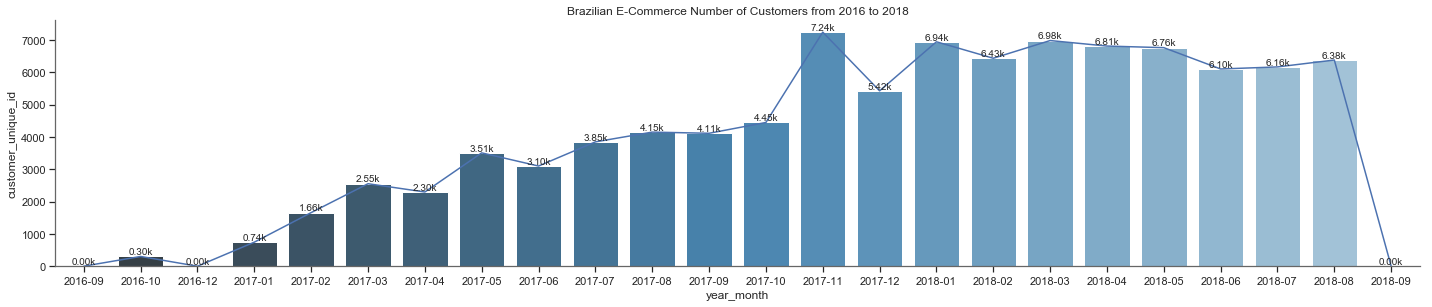

In [217]:
fig, ax = plt.subplots(figsize=(20, 4.5))
ax = sns.lineplot(x='year_month', y='customer_unique_id', data=df_cus_count)
bar_plot(x='year_month', y='customer_unique_id', df=df_cus_count, value=True)
format_spines(ax, right_border=False)
ax.set_title('Brazilian E-Commerce Number of Customers from 2016 to 2018')
plt.show()

In [218]:
df_cus_state = df.groupby(['customer_state','order_purchase_year'], as_index=False).sum().loc[:, ['customer_state','order_purchase_year', 'payment_value']].sort_values(by='payment_value', ascending=False)
df_cus_state.head(10)

customer_state  order_purchase_year  payment_value
72             SP                 2018     4363136.98
71             SP                 2017     3170002.61
51             RJ                 2017     1367630.83
52             RJ                 2018     1366640.42
29             MG                 2018     1231548.90
28             MG                 2017     1071657.48
63             RS                 2018      592221.03
49             PR                 2018      589263.57
62             RS                 2017      537690.87
48             PR                 2017      463667.69

Based on the above table, the biggest five states: SP, RJ, MG, RS, and PR
Their sale patterns are similar, on the decline. SP dominates the overall sale figure, so let's isolate it out.****

In [240]:
df_cus_state = df.groupby(['customer_state','year_month'], as_index=False).sum().loc[:, ['customer_state','year_month', 'payment_value']].sort_values(by='payment_value', ascending=False)

In [220]:
df_cus_state.head()

customer_state year_month  payment_value
533             SP    2018-05      629480.84
532             SP    2018-04      577568.07
531             SP    2018-03      565829.35
536             SP    2018-08      561962.03
529             SP    2018-01      537041.34

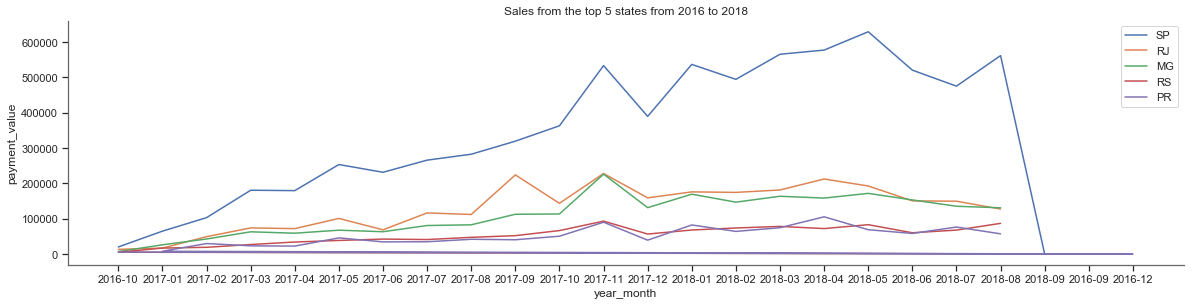

In [222]:

top5 = ['SP', 'RJ','MG','RS','PR']
df_top5_state = df_cus_state.loc[df_cus_state['customer_state'].isin(top5)]
df_top5_state.head(3)

fig, ax = plt.subplots(figsize=(20, 4.5))
for state in top5:
    ax = sns.lineplot(x='year_month', y='payment_value', data=df_top5_state[df_top5_state['customer_state']==state], label=state)
format_spines(ax, right_border=False)
ax.set_title('Sales from the top 5 states from 2016 to 2018');

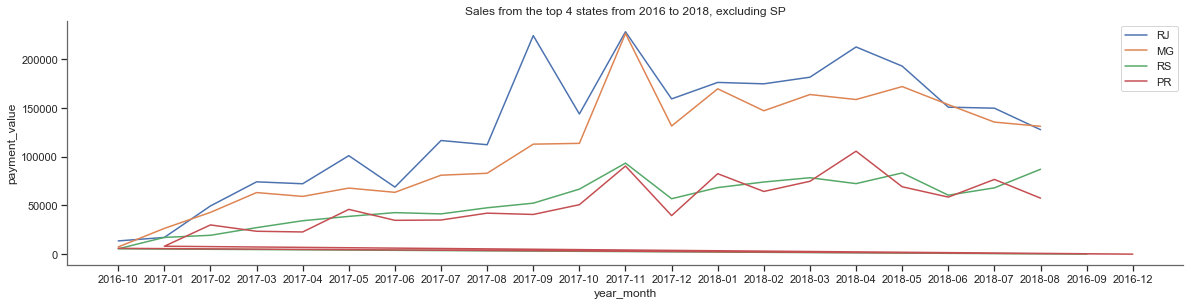

In [223]:
top4_noSP = ['RJ','MG','RS','PR']
df_top4_noSP = df_cus_state.loc[df_cus_state['customer_state'].isin(top4_noSP)]
df_top4_noSP.head(3)

fig, ax = plt.subplots(figsize=(20, 4.5))
for state in top4_noSP:
    ax = sns.lineplot(x='year_month', y='payment_value', data=df_top4_noSP[df_top4_noSP['customer_state']==state], label=state)
format_spines(ax, right_border=False)
ax.set_title('Sales from the top 4 states from 2016 to 2018, excluding SP');

All other top 4 states suffer from the same decline as SP.
Since the sale decline happened in 2018 across all states, there could be only two reasons: 
* Competitors launch something in Brazil, attracting customers/sales to their sites. The top 3 states are all trending down in the past 3 to 4 months. 
* There are some serious bugs/business strategy changes

Since the case assumed no major bugs, the first hypothesis is the most reasonable one.
This hypothesis is further confirmed here "The company **Amazon** made its first big move into merchandise in October 2017, when it began offering the use of its Brazilian website to third-party merchants to sell electronics." [Read more...](https://www.reuters.com/article/us-amazon-com-brazil/amazon-com-starts-direct-sales-of-merchandise-in-brazil-after-delays-idUSKCN1PG0AG)

# Sellers
The number of sellers is still increasing MoM, despite a reduced in order volume

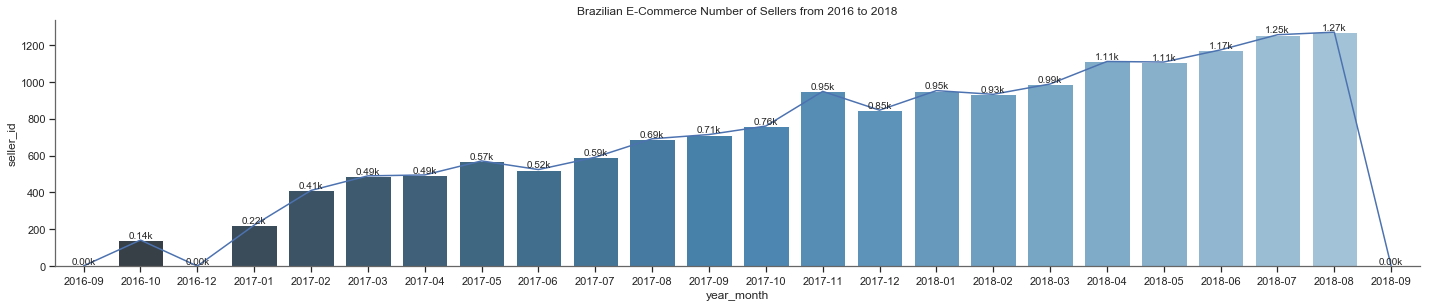

In [224]:
fig, ax = plt.subplots(figsize=(20, 4.5))
ax = sns.lineplot(x='year_month', y='seller_id', data=df_cus_count)
bar_plot(x='year_month', y='seller_id', df=df_cus_count, value=True)
format_spines(ax, right_border=False)
ax.set_title('Brazilian E-Commerce Number of Sellers from 2016 to 2018')
plt.show()

# Churn Analysis

In [225]:
#Create a dataframe to count how many times a customer shop 
df_order = df.groupby(['order_id','year_month','order_purchase_year','customer_unique_id'], as_index=False).sum().loc[:, ['order_id','customer_unique_id','year_month','order_purchase_year', 'payment_value']].sort_values(by='year_month', ascending=True)
df_order['shop_times']=df_order.groupby(['customer_unique_id']).cumcount() + 1 #cumcount() starts at 0, add 1 so that it starts at 1

df_order_2016 = df_order[df_order['order_purchase_year']==2016]
df_order_2017 = df_order[df_order['order_purchase_year']==2017]
df_order_2018 = df_order[df_order['order_purchase_year']==2018]

In [226]:
df_count_cust = df_order.groupby(['customer_unique_id']).count().reset_index()
df_count_cust["order_count"] = df_count_cust["order_id"]
df_count_cust = df_count_cust.drop(["order_id", "year_month", "payment_value", "shop_times","order_purchase_year"], axis=1)
df_count_cust = df_count_cust.groupby(["order_count"]).count().reset_index().rename(columns={"customer_unique_id": "num_customer"})
df_count_cust["percentage_customer"] = 100.0 * df_count_cust["num_customer"] / df_count_cust["num_customer"].sum()
df_count_cust

order_count  num_customer  percentage_customer
0            1         91238            96.971951
1            2          2617             2.781468
2            3           185             0.196627
3            4            30             0.031885
4            5             9             0.009566
5            6             3             0.003189
6            7             3             0.003189
7            9             1             0.001063
8           15             1             0.001063

96% of customers only buy with Olist once, which is a big problem. 

In [227]:
df_count_cust= df_order_2016.groupby(['customer_unique_id']).count().reset_index()
df_count_cust["order_count"] = df_count_cust["order_id"]
df_count_cust = df_count_cust.drop(["order_id", "year_month", "payment_value", "shop_times"], axis=1)
df_count_cust = df_count_cust.groupby(["order_count"]).count().reset_index().rename(columns={"customer_unique_id": "num_customer"})
df_count_cust["percentage_customer"] = 100.0 * df_count_cust["num_customer"] / df_count_cust["num_customer"].sum()
df_count_cust

order_count  num_customer  order_purchase_year  percentage_customer
0            1           303                  303            99.019608
1            2             3                    3             0.980392

In [228]:
df_count_cust= df_order_2017.groupby(['customer_unique_id']).count().reset_index()
df_count_cust["order_count"] = df_count_cust["order_id"]
df_count_cust = df_count_cust.drop(["order_id", "year_month", "payment_value", "shop_times"], axis=1)
df_count_cust = df_count_cust.groupby(["order_count"]).count().reset_index().rename(columns={"customer_unique_id": "num_customer"})
df_count_cust["percentage_customer"] = 100.0 * df_count_cust["num_customer"] / df_count_cust["num_customer"].sum()
df_count_cust

order_count  num_customer  order_purchase_year  percentage_customer
0            1         41277                41277            97.186382
1            2          1102                 1102             2.594651
2            3            75                   75             0.176587
3            4            12                   12             0.028254
4            5             4                    4             0.009418
5            6             1                    1             0.002354
6            8             1                    1             0.002354

In [229]:
df_count_cust= df_order_2018.groupby(['customer_unique_id']).count().reset_index()
df_count_cust["order_count"] = df_count_cust["order_id"]
df_count_cust = df_count_cust.drop(["order_id", "year_month", "payment_value", "shop_times", 'order_purchase_year'], axis=1)
df_count_cust = df_count_cust.groupby(["order_count"]).count().reset_index().rename(columns={"customer_unique_id": "num_customer"})
df_count_cust["percentage_customer"] = 100.0 * df_count_cust["num_customer"] / df_count_cust["num_customer"].sum()
df_count_cust

order_count  num_customer  percentage_customer
0            1         50864            97.873732
1            2          1038             1.997345
2            3            56             0.107757
3            4             8             0.015394
4            5             1             0.001924
5            6             1             0.001924
6            7             1             0.001924

The Olist stores has new customers every year, but they seem not to continue patronizing them.

# Rootcause Analysis
Why 96% of customers shop with us only once? Key factors include
* Price
* Customer Experience - proxy by Review
* Delivery Duration 

****Since we have review scores and order delivery time, we will focus here first. 


In [230]:
#checking the average shipping time for top cities
df_state = df.groupby(['order_purchase_year', 'customer_state'], as_index=False).mean().loc[:, ['order_purchase_year','customer_state','expected_duration','ship_duration', 'tocarrier_duration', 'lastmile_duration','expected_vs_shipdate','review_score']].sort_values(by=['ship_duration'], ascending=True)
df_state.head(10)

order_purchase_year customer_state  expected_duration  ship_duration  \
8                  2016             MT          62.000000       7.000000   
73                 2018             SP          17.719385       7.786536   
16                 2016             RR          52.000000       8.000000   
46                 2017             SP          20.380390       8.874603   
65                 2018             PR          23.439876      11.106550   
58                 2018             MG          23.573031      11.398071   
31                 2017             MG          24.933628      11.580090   
54                 2018             DF          22.740175      11.951327   
38                 2017             PR          25.202196      11.955650   
27                 2017             DF          25.717051      13.122740   

    tocarrier_duration  lastmile_duration  expected_vs_shipdate  review_score  
8            15.666667           3.000000             55.000000      3.666667  
73            2.504143           4.818908              9.573544      4.126423  
16           30.333333           3.000000             57.000000      2.000000  
46            2.940888           5.438325             11.009243      4.107771  
65            2.563472           8.068004             11.984331      4.080989  
58            2.553017           8.369272             11.796851      4.022848  
31            2.989775           8.137022             12.872467      4.127542  
54            2.579139           8.951327             10.398230      4.020378  
38            3.100383           8.384111             12.777863      4.119273  
27            3.026217           9.592769             12.004757      3.953917

The states(PR, SP, MG) from which most sales where made have low average delivery time which would have enhanced the orders from these cities.

In [231]:
# Average shipping time and review scores
df_quality = df.groupby(['order_purchase_year'], as_index=False).mean().loc[:, ['order_purchase_year','expected_duration','ship_duration', 'tocarrier_duration', 'lastmile_duration','expected_vs_shipdate','review_score']]
df_quality.head(10)

order_purchase_year  expected_duration  ship_duration  tocarrier_duration  \
0                 2016          55.353093      19.655882           14.142450   
1                 2017          24.388553      12.458669            3.001723   
2                 2018          22.579756      11.613650            2.560461   

   lastmile_duration  expected_vs_shipdate  review_score  
0           5.485294             35.055882      3.561856  
1           8.974802             11.449063      4.033041  
2           8.583406             10.600364      4.007279

Although our review score is not too bad, we have a very long end-to-end ship duration. The review score is high because our expected delivery date is almost a month, which is almost not exceeded every time. As indicated in the dataset documentation, the customers are sent a review form on delivery or when estimated delivery date is reached. They would generally give a good review score as it does not exceed the expected delivery date.

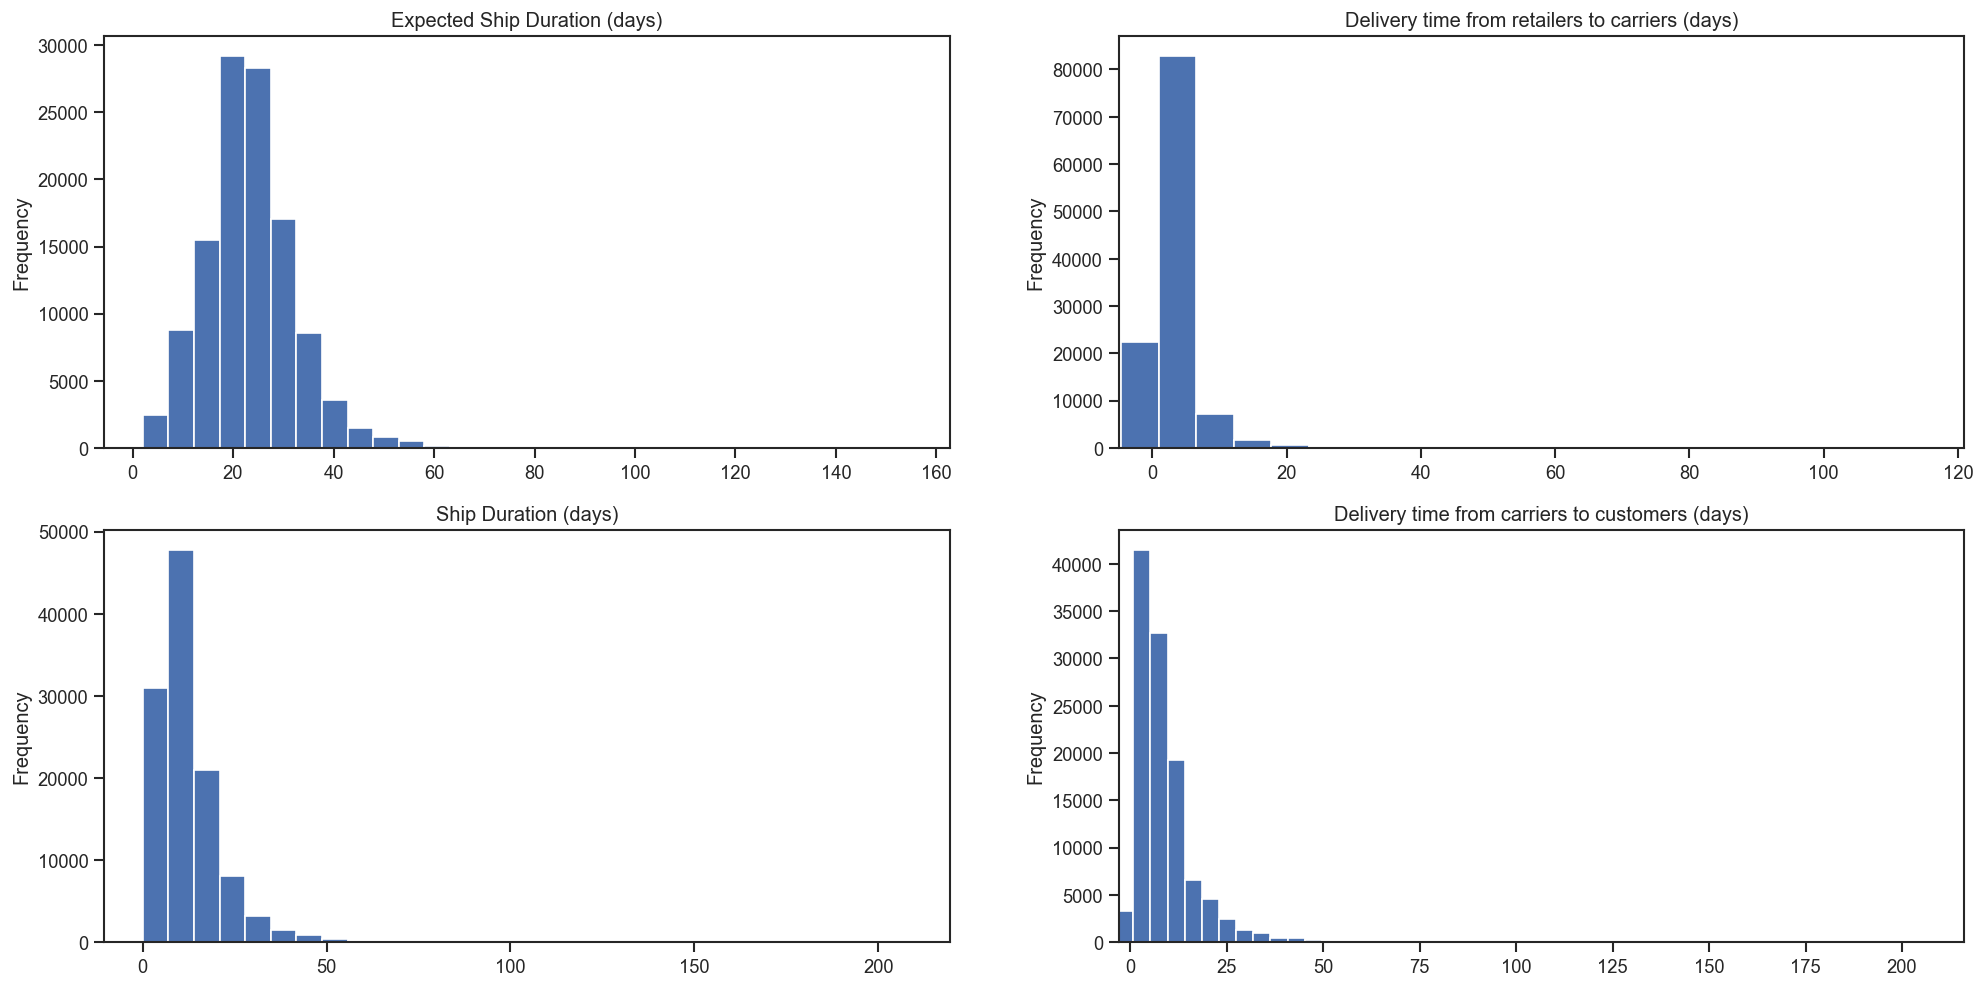

In [239]:
#Let's visualize the different delivery times
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,10),dpi=120)

df['expected_duration'].plot.hist(bins=30, alpha = 1,ax = axes[0,0])
axes[0,0].set_title('Expected Ship Duration (days)')

df['ship_duration'].plot.hist(bins=30, alpha = 1,ax = axes[1,0])
axes[1,0].set_title('Ship Duration (days)')

df['tocarrier_duration'].plot.hist(bins=50, alpha = 1,ax = axes[0,1])
axes[0,1].set_title('Delivery time from retailers to carriers (days)')
axes[0,1].set_xlim(-5,);

df['lastmile_duration'].plot.hist(bins=50, alpha = 1,ax = axes[1,1])
axes[1,1].set_title('Delivery time from carriers to customers (days)')
axes[1,1].set_xlim(-3,);

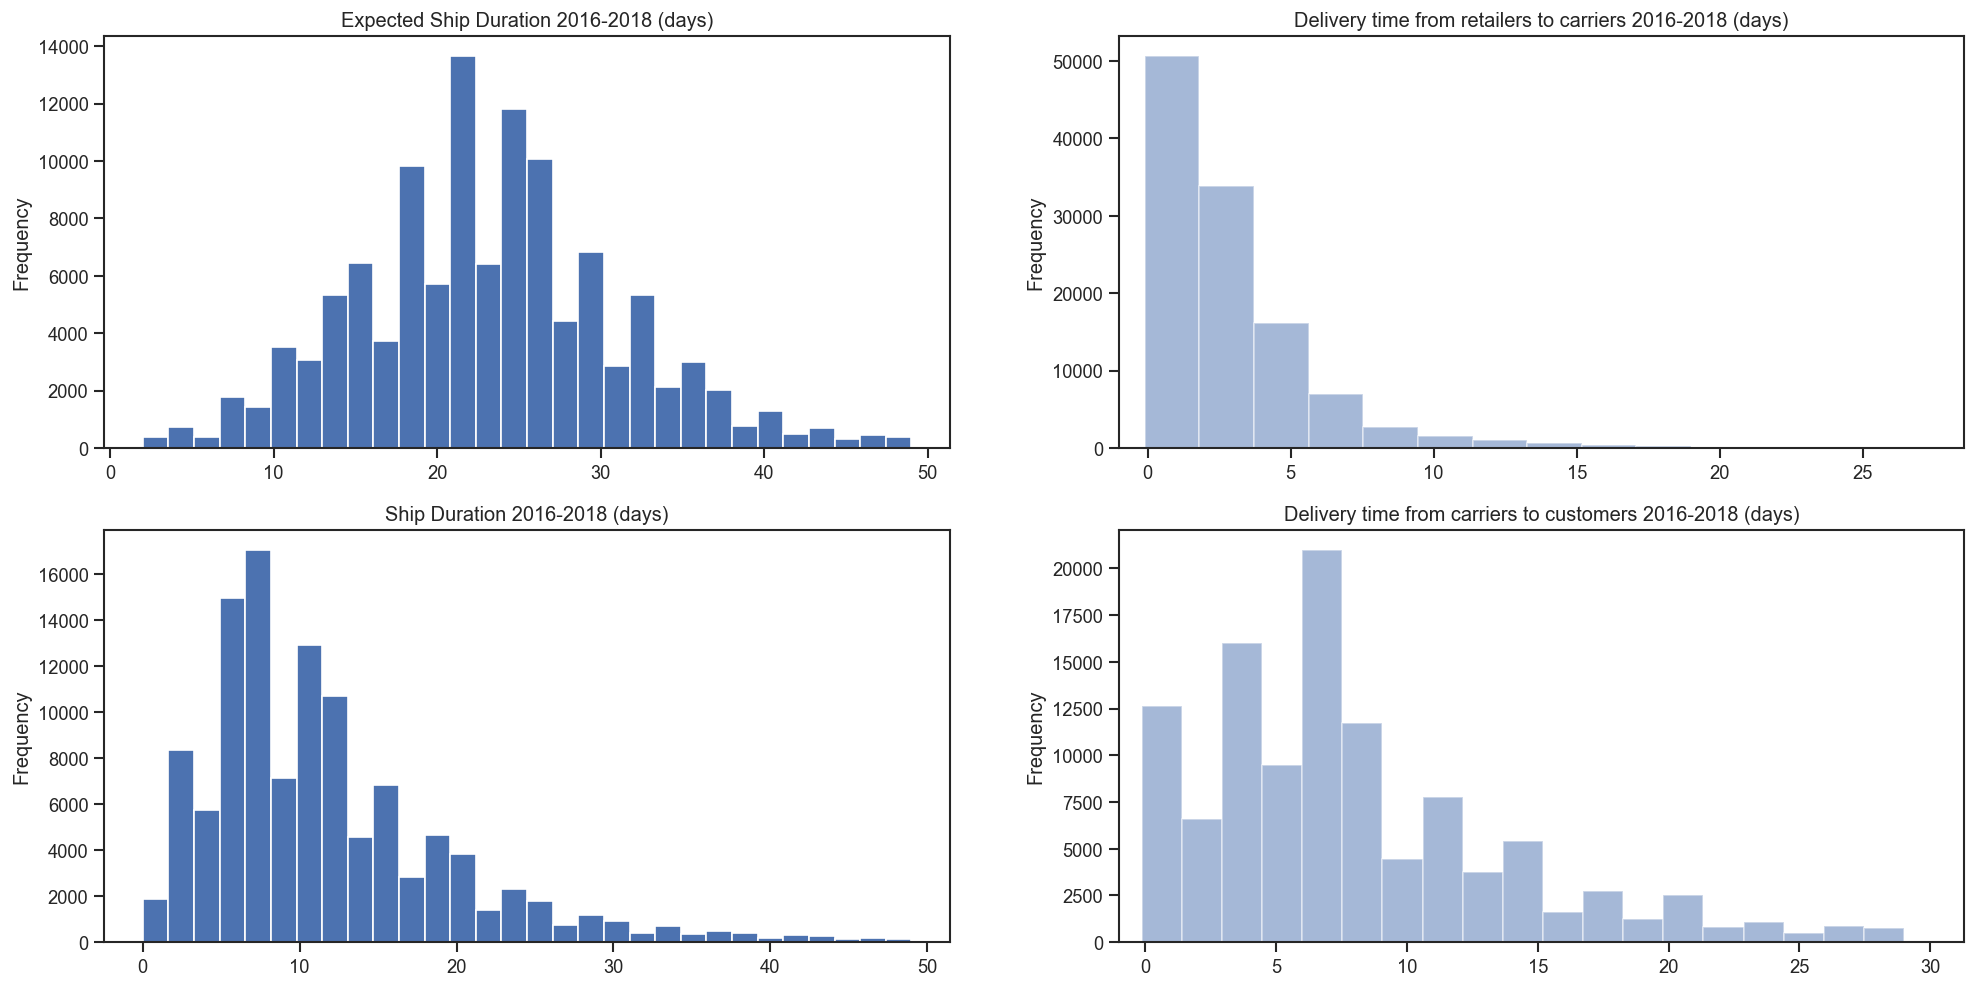

In [233]:
#drop outliers to make the histograms clearer
df_quality_chart_1 = df[df.expected_duration < 50] #drop any expected duration more than 60 days from purchase date
df_quality_chart_2 = df[df.ship_duration < 50] #drop any shipping duration more than 60 days from purchase date
df_quality_chart_3 = df[(df['tocarrier_duration'] < 20)]
df_quality_chart_4 = df[(df['lastmile_duration'] < 30)] 


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,10),dpi=120)

df_quality_chart_1['expected_duration'].plot.hist(bins=30, alpha = 1,ax = axes[0,0])
axes[0,0].set_title('Expected Ship Duration 2016-2018 (days)')

df_quality_chart_2['ship_duration'].plot.hist(bins=30, alpha = 1,ax = axes[1,0])
axes[1,0].set_title('Ship Duration 2016-2018 (days)')

df_quality_chart_3['tocarrier_duration'].plot.hist(bins=100, alpha = 0.5,ax = axes[0,1])
axes[0,1].set_title('Delivery time from retailers to carriers 2016-2018 (days)')
axes[0,1].set_xlim(-1,);

df_quality_chart_4['lastmile_duration'].plot.hist(bins=30, alpha = 0.5,ax = axes[1,1])
axes[1,1].set_title('Delivery time from carriers to customers 2016-2018 (days)');
axes[1,1].set_xlim(-1,);


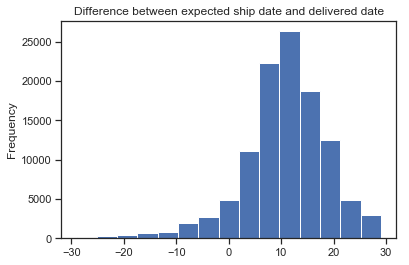

In [234]:
df_quality_chart_5['expected_vs_shipdate'].plot.hist(bins=15, alpha = 1)
plt.title("Difference between expected ship date and delivered date");

This delivery performance won't keep any customers. Average duration to ship is between 15-30 days!

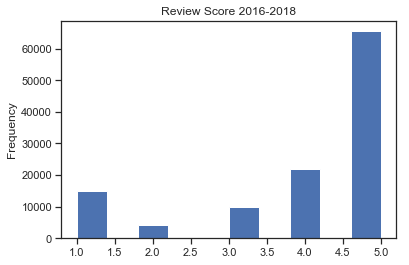

In [235]:
df['review_score'].plot.hist(bins=10, alpha = 1)
plt.title("Review Score 2016-2018");

#### <u>Recommendations</u>
1. Olist stores should ensure reduced delivery time for ordered goods.
2. Improve their logistics on good delivery
3. They could establish stores in different cities to enhance quick delivery - Olist Stores is located in Curitiba - PR(Puerto Rico). Majority of orders from same state were delivered on time and have high review scores.
4. The top cities with high orders and sales showed a small average delivery time which indicates that delivery time is a major cause of customer churn